In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold
import random
from tensorflow.keras import models, layers  # Import models and layers
from scipy.ndimage import rotate
from skimage.transform import resize
import scipy.ndimage
from tensorflow.keras.callbacks import Callback
from sklearn.model_selection import train_test_split

2024-12-13 15:24:40.205734: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1734121480.427400     483 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1734121480.488515     483 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-13 15:24:41.069822: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Load MNIST data
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Normalize the data to range [0, 1]
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

# Add channel dimension for CNN
x_train = x_train[..., np.newaxis]  # Shape (60000, 28, 28, 1)
x_test = x_test[..., np.newaxis]    # Shape (10000, 28, 28, 1)

# One-hot encode the labels
y_train = tf.keras.utils.to_categorical(y_train, 10)
y_test = tf.keras.utils.to_categorical(y_test, 10)

In [3]:
#Verify if TensorFlow is using your GPU  
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print("Num GPUs Available: ", len(gpus))
else:
    print("No GPUs found")

Num GPUs Available:  1


In [4]:
# CNN model
def cnn_model(input_shape):
    model = models.Sequential([
        layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dense(10, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [5]:
# Cross-Validation (This Function was taken out of the Paper)
def cross_validate_cnn(x, y, n_splits=5, epochs=5, batch_size=64):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    fold_accuracies = []

    for train_index, val_index in kf.split(x):
        x_fold_train, x_fold_val = x[train_index], x[val_index]
        y_fold_train, y_fold_val = y[train_index], y[val_index]

        # Build and train the model
        model = cnn_model(input_shape=(28, 28, 1))
        model.fit(x_fold_train, y_fold_train, epochs=epochs, batch_size=batch_size, verbose=0)

        # Evaluate on validation set
        val_loss, val_accuracy = model.evaluate(x_fold_val, y_fold_val, verbose=0)
        fold_accuracies.append(val_accuracy)

    return np.mean(fold_accuracies), np.std(fold_accuracies)

In [6]:
# Accuracy vs Training Set Size
def plot_learning_curve(x, y, fractions, n_splits=5, epochs=5, batch_size=64):
    mean_accuracies = []
    std_accuracies = []

    for fraction in fractions:
        # Subset the data
        num_samples = int(len(x) * fraction)
        indices = random.sample(range(len(x)), num_samples)
        x_subset, y_subset = x[indices], y[indices]

        # Perform cross-validation on the subset
        mean_acc, std_acc = cross_validate_cnn(x_subset, y_subset, n_splits=n_splits, epochs=epochs, batch_size=batch_size)
        mean_accuracies.append(mean_acc)
        std_accuracies.append(std_acc)

    # Plot Accuracy vs Training Set Size
    plt.figure(figsize=(10, 6))
    plt.errorbar(fractions, mean_accuracies, yerr=std_accuracies, fmt='-o', capsize=5)
    plt.title('Accuracy vs Training Set Size')
    plt.xlabel('Fraction of Training Set Used')
    plt.ylabel('Cross-Validated Accuracy')
    plt.grid(True)
    plt.show()


Cross-validated Accuracy: 0.9870 ± 0.0010
Test Set Accuracy: 0.9912
Test Set Error Rate: 0.0088


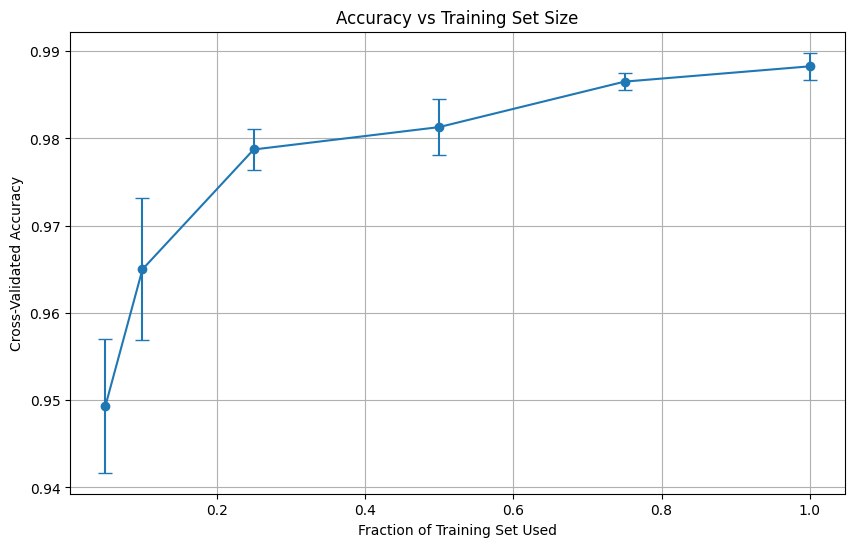

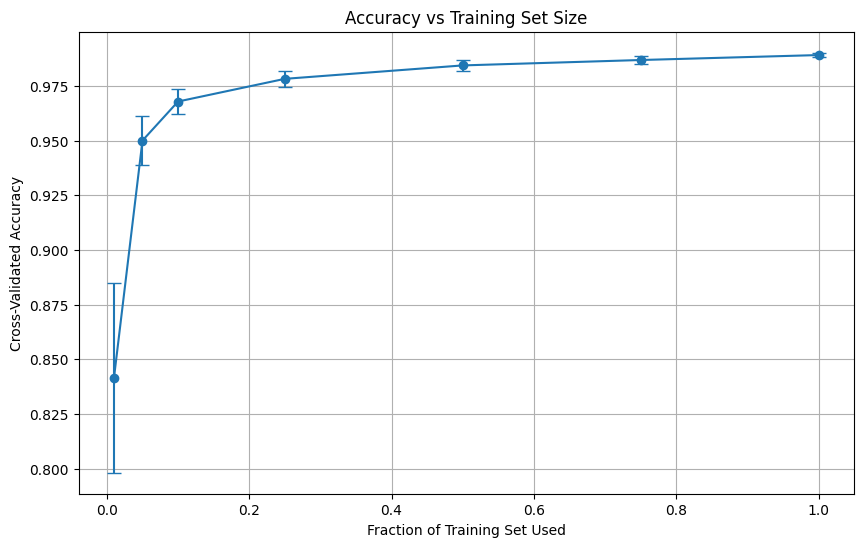

In [9]:
random.seed(2424)

#Perform cross-validation on the Original
mean_acc, std_acc = cross_validate_cnn(x_train, y_train, n_splits=5, epochs=5, batch_size=64)

# Evaluate test set
model = cnn_model(input_shape=(28, 28, 1))
model.fit(x_train, y_train, epochs=5, batch_size=64, verbose=0)
test_loss, test_accuracy = model.evaluate(x_test, y_test, verbose=0)

# Print results
print(f"Cross-validated Accuracy: {mean_acc:.4f} ± {std_acc:.4f}")
print(f"Test Set Accuracy: {test_accuracy:.4f}")
print(f"Test Set Error Rate: {1 - test_accuracy:.4f}")

# Plot the Curve
fractions = [1.0, 0.75, 0.5, 0.25, 0.1, 0.05]
fractions_1 = [1.0, 0.75, 0.5, 0.25, 0.1, 0.05, 0.01]
plot_learning_curve(x_train, y_train, fractions, n_splits=5, epochs=5, batch_size=64)

plot_learning_curve(x_train, y_train, fractions_1, n_splits=5, epochs=5, batch_size=64)

In [10]:
# Function to get the most and least typical images based on PCA (This Function was taken out of the Paper)
def get_typical_and_outlier_images_pca(images, num_images=5, variance_threshold=0.9):
    """
    Identifies the most typical and outlier images for a given set of images based on PCA.

    Parameters:
    - images (np.ndarray): Array of images with shape (n_samples, 28, 28, 1).
    - num_images (int): Number of typical and outlier images to return.
    - variance_threshold (float): Proportion of variance to retain in PCA.

    Returns:
    - typical_images (np.ndarray): Most typical images.
    - outlier_images (np.ndarray): Most outlier images.
    """
    # Flatten images for PCA (28x28 -> 784 features)
    flattened_images = images.reshape(images.shape[0], -1)  # Shape: (n_samples, 784)

    # Apply PCA
    pca = PCA()
    pca.fit(flattened_images)

    # Find number of components to explain desired variance
    cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
    n_components = np.where(cumulative_variance >= variance_threshold)[0][0] + 1

    # Project images to reduced PCA space
    reduced_images = pca.transform(flattened_images)[:, :n_components]

    # Calculate distance of each image from the mean in PCA space
    mean_reduced_image = np.mean(reduced_images, axis=0)
    distances = np.linalg.norm(reduced_images - mean_reduced_image, axis=1)

    # Find most typical and outlier indices
    most_typical_indices = np.argsort(distances)[:num_images]  # Closest to mean
    most_different_indices = np.argsort(distances)[-num_images:]  # Farthest from mean

    return images[most_typical_indices], images[most_different_indices]

In [11]:
# Visualize the most typical and outlier images (This Function was taken out of the Paper)
def visualize_typical_outlier_images_subset(x_data, y_data, digit, num_images=5):
    """
    Visualize the most typical and outlier images for a specific digit in the reduced subset.

    Parameters:
    - x_data (np.ndarray): Images in the reduced subset.
    - y_data (np.ndarray): Labels corresponding to the images.
    - digit (int): The digit to analyze (0-9).
    - num_images (int): Number of typical and outlier images to visualize.
    """
    # Filter the subset for the given digit
    digit_indices = np.argmax(y_data, axis=1) == digit
    digit_images = x_data[digit_indices]

    # Get typical and outlier images
    typical_images, outlier_images = get_typical_and_outlier_images_pca(digit_images, num_images)

    # Plot typical and outlier images
    plt.figure(figsize=(12, 6))
    plt.suptitle(f"Most Typical and Outlier Images for Digit {digit} (5% Subset)")

    # Plot typical images
    for i, image in enumerate(typical_images):
        plt.subplot(2, num_images, i + 1)
        plt.imshow(image.squeeze(), cmap='gray')
        plt.title("Typical")
        plt.axis('off')

    # Plot outlier images
    for i, image in enumerate(outlier_images):
        plt.subplot(2, num_images, num_images + i + 1)
        plt.imshow(image.squeeze(), cmap='gray')
        plt.title("Outlier")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

In [7]:
random.seed(2424)
# Randomly select 5% of the MNIST training data
fraction = 0.05
num_samples = int(len(x_train) * fraction)
indices = random.sample(range(len(x_train)), num_samples)
x_subset, y_subset = x_train[indices], y_train[indices]

# Define the rotation angles
rotation_angles_list1 = [angle for angle in range(-45, 50, 5) if angle != 0]  # -45 to 45 degrees in steps of 5
rotation_angles_list2 = [angle for angle in range(-90, 95, 5) if angle != 0]  # -90 to 90 degrees in steps of 5
rotation_angles_list3 = [angle for angle in range(-180, 185, 5) if angle != 0]  # -180 to 90 degrees in steps of 5

padding_size = 8  # Padding to prevent digit cutoff


Analyzing digit 0:


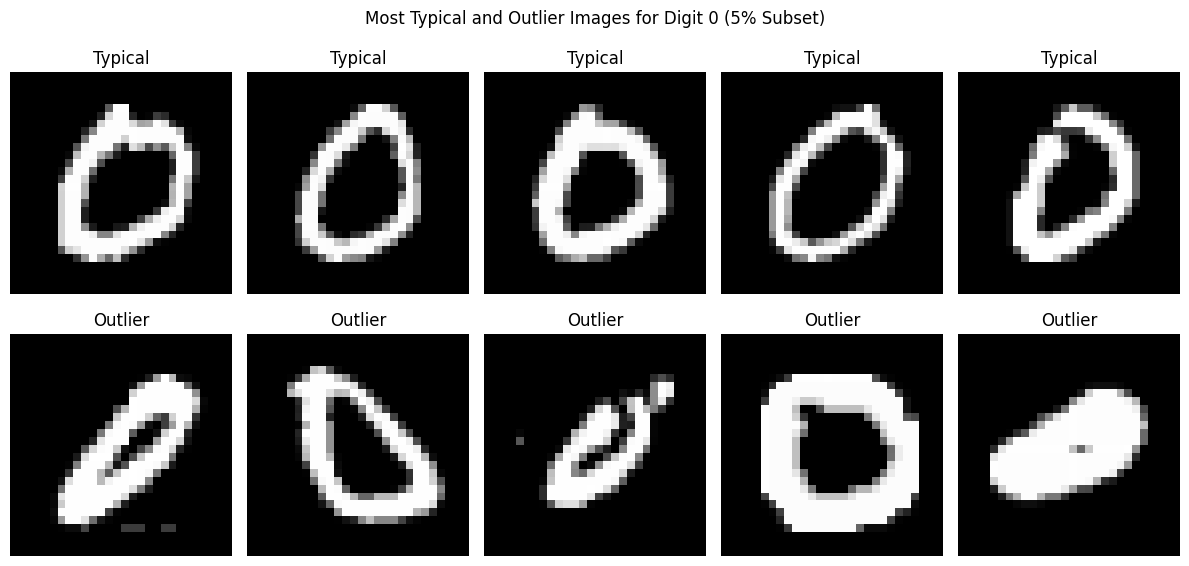


Analyzing digit 1:


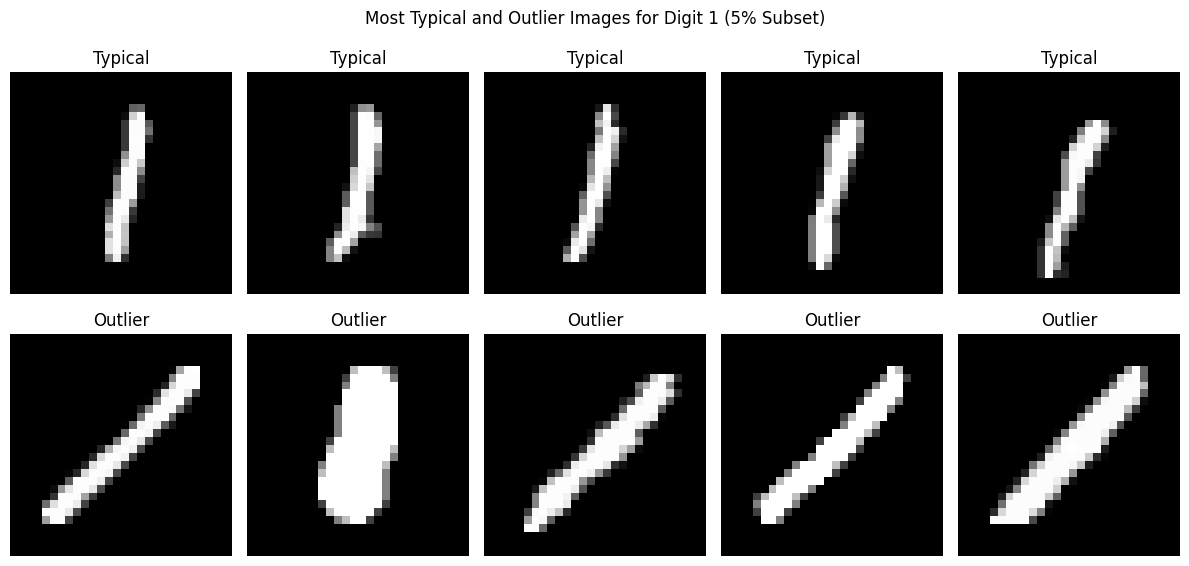


Analyzing digit 2:


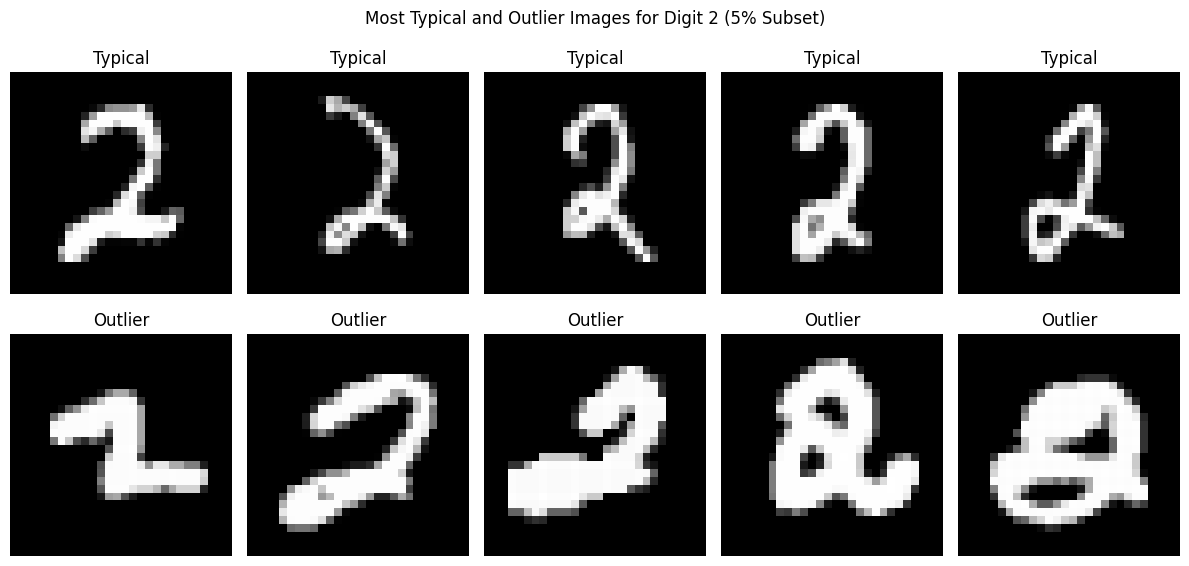


Analyzing digit 3:


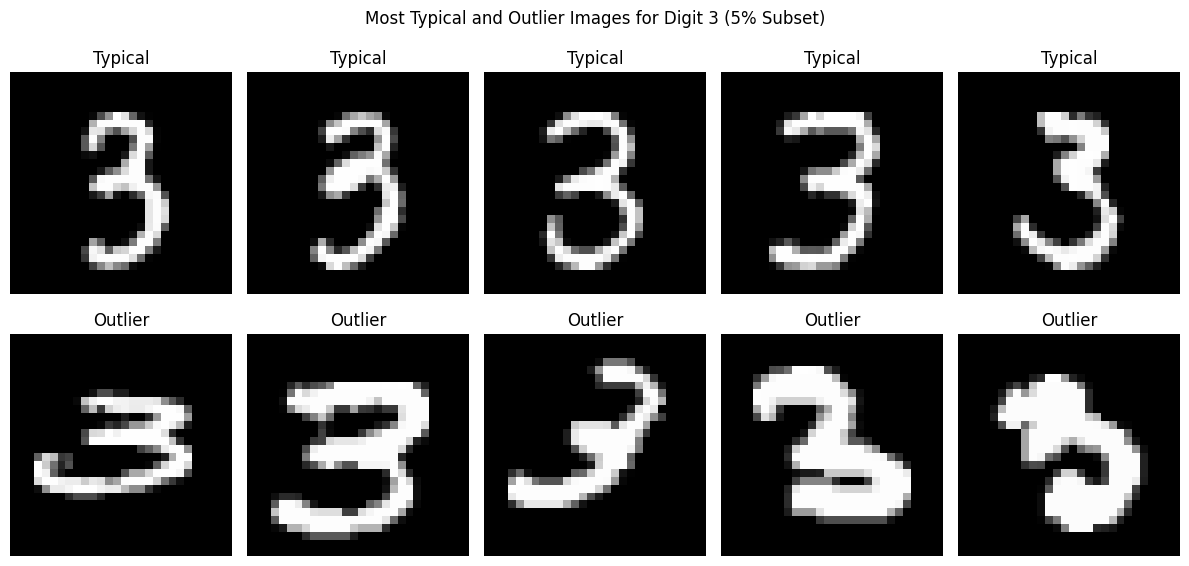


Analyzing digit 4:


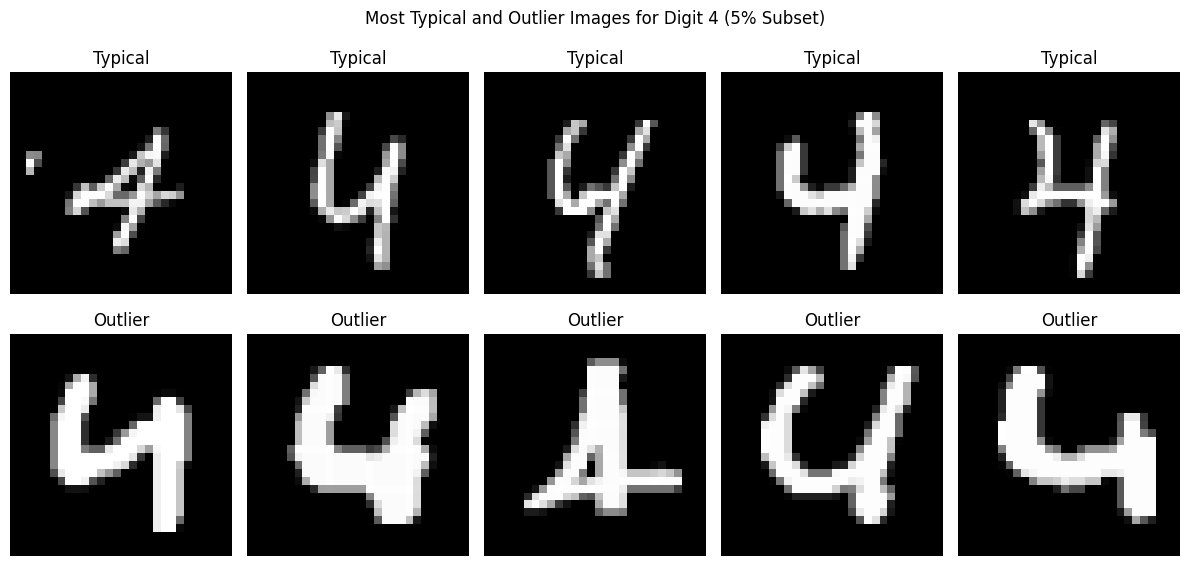


Analyzing digit 5:


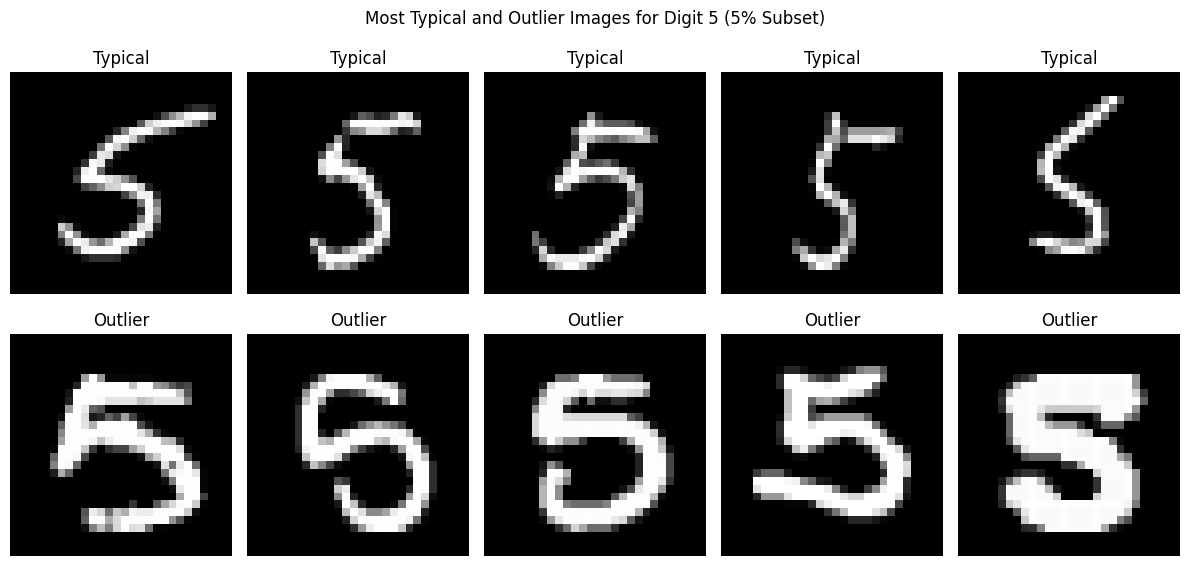


Analyzing digit 6:


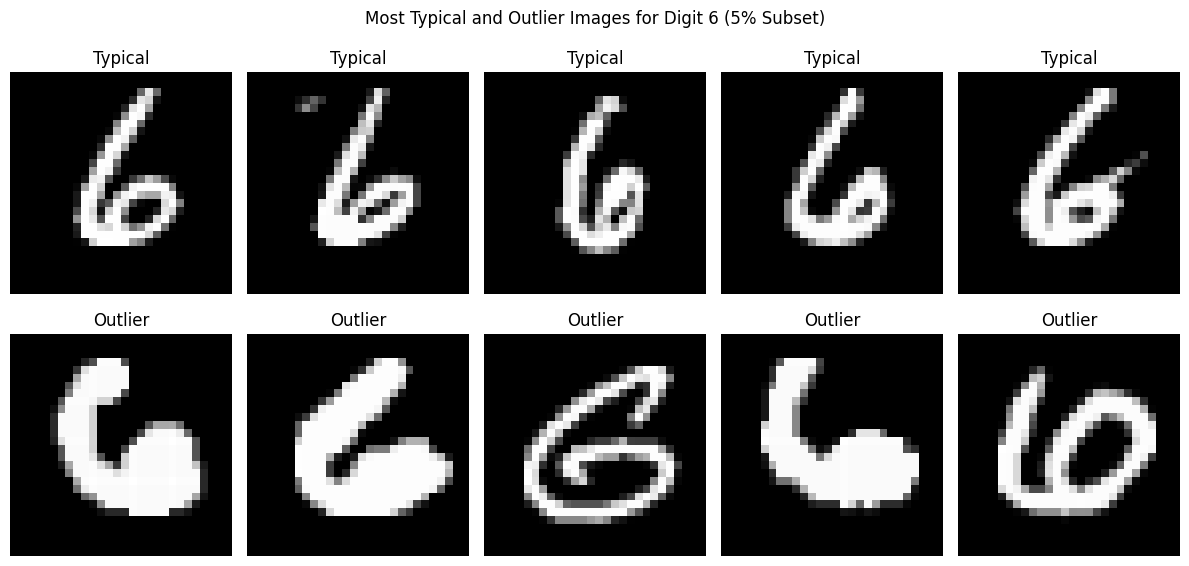


Analyzing digit 7:


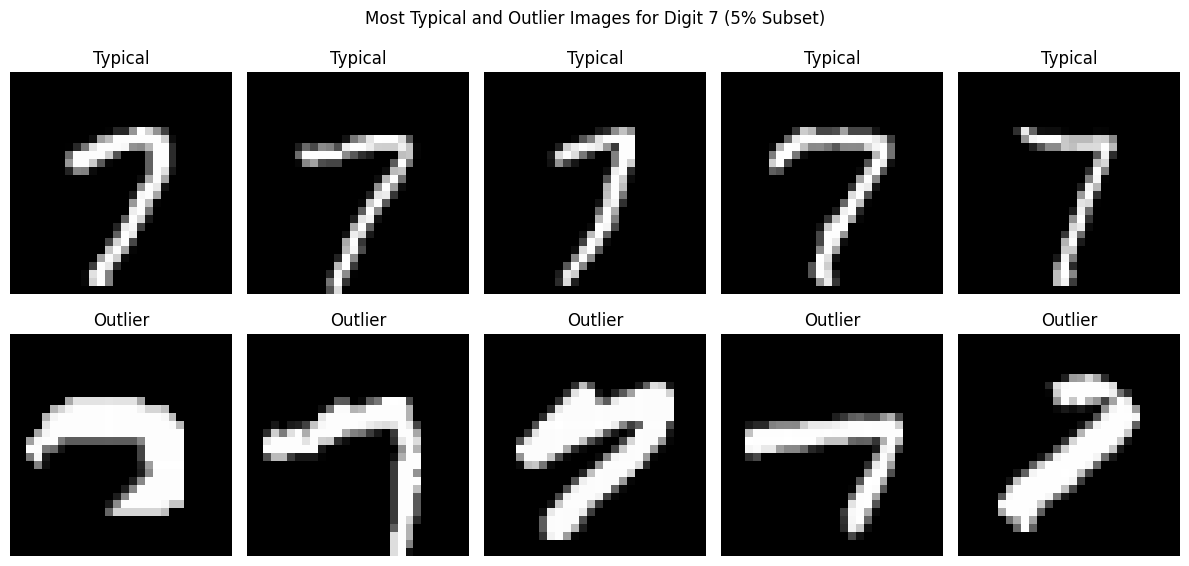


Analyzing digit 8:


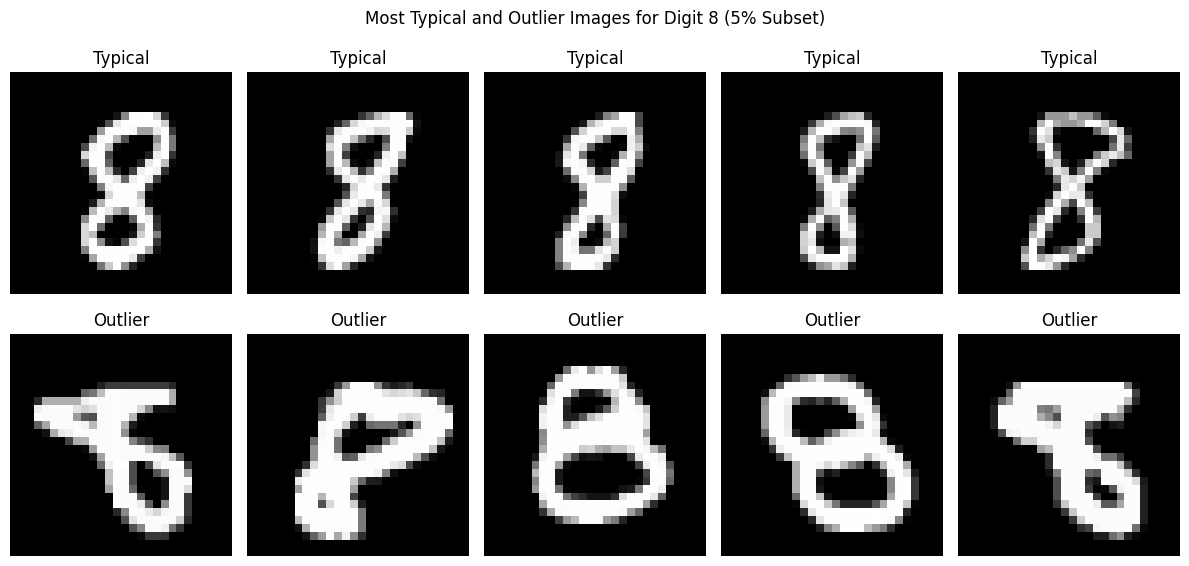


Analyzing digit 9:


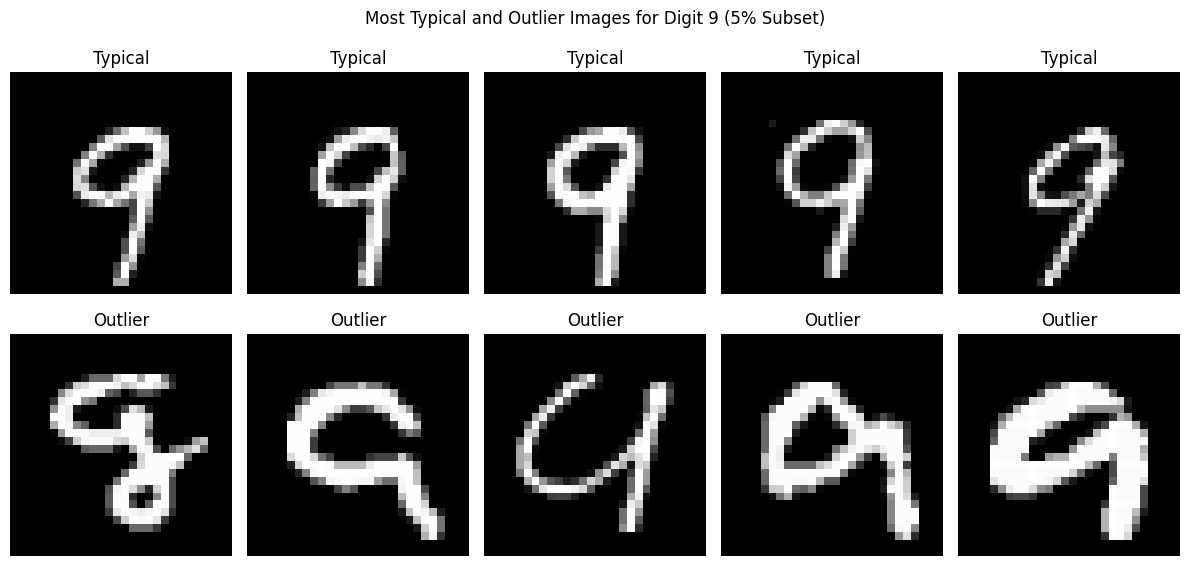

In [13]:
# Visualize typical and outlier images for each digit (0–9) (This Function was taken out of the Paper)
for digit in range(10):
    print(f"\nAnalyzing digit {digit}:")
    visualize_typical_outlier_images_subset(x_subset, y_subset, digit=digit, num_images=5)

In [8]:
# Function to pad, rotate, and resize images
def pad_rotate_resize_images(images, angles, target_size=(28, 28)):
    """
    Pads, rotates, and resizes the given images.

    Parameters:
    - images (np.ndarray): Array of images to be processed (n_samples, 28, 28, 1).
    - angles (list of int): List of angles to rotate the images.
    - target_size (tuple of int): Final size of the images after resizing (height, width).

    Returns:
    - augmented_images (np.ndarray): Rotated and resized images.
    """
    augmented_images = []

    for image in images:
        # Pad the image
        padded_image = np.pad(image, ((padding_size, padding_size), (padding_size, padding_size), (0, 0)), mode='constant', constant_values=0)

        # Rotate and resize the padded image for each angle
        for angle in angles:
            rotated_image = rotate(padded_image, angle, reshape=False, mode='constant', cval=0)
            resized_image = resize(rotated_image, target_size, mode='constant', anti_aliasing=True)
            augmented_images.append(resized_image)

    return np.array(augmented_images)

In [9]:
# Process the data for rotation_angles_list1
x_augmented_list1 = pad_rotate_resize_images(x_subset, rotation_angles_list1)
y_augmented_list1 = np.repeat(y_subset, len(rotation_angles_list1), axis=0)

# Process the data for rotation_angles_list2
x_augmented_list2 = pad_rotate_resize_images(x_subset, rotation_angles_list2)
y_augmented_list2 = np.repeat(y_subset, len(rotation_angles_list2), axis=0)

# Process the data for rotation_angles_list3
x_augmented_list3 = pad_rotate_resize_images(x_subset, rotation_angles_list3)
y_augmented_list3 = np.repeat(y_subset, len(rotation_angles_list3), axis=0)

# Combine data for each case
x_combined_list1 = np.concatenate((x_subset, x_augmented_list1), axis=0)
y_combined_list1 = np.concatenate((y_subset, y_augmented_list1), axis=0)

x_combined_list2 = np.concatenate((x_subset, x_augmented_list2), axis=0)
y_combined_list2 = np.concatenate((y_subset, y_augmented_list2), axis=0)

x_combined_list3 = np.concatenate((x_subset, x_augmented_list3), axis=0)
y_combined_list3 = np.concatenate((y_subset, y_augmented_list3), axis=0)

# Print results
print(f"Original 5% subset size: {x_subset.shape[0]}")
print(f"Augmented subset size (including original, from -45 to 45 degrees): {x_combined_list1.shape[0]}")
print(f"Augmented subset size (including original, from -90 to 90 degrees): {x_combined_list2.shape[0]}")
print(f"Augmented subset size (including original, from -180 to 180 degrees): {x_combined_list3.shape[0]}")

Original 5% subset size: 3000
Augmented subset size (including original, from -45 to 45 degrees): 57000
Augmented subset size (including original, from -90 to 90 degrees): 111000
Augmented subset size (including original, from -180 to 180 degrees): 219000


In [10]:
# Cross-validation on the original 5% subset
mean_acc_original, std_acc_original = cross_validate_cnn(x_subset, y_subset, n_splits=5, epochs=5, batch_size=64)

# Evaluate on the original 5% subset
model = cnn_model(input_shape=(28, 28, 1))
model.fit(x_subset, y_subset, epochs=5, batch_size=64, verbose=0)
test_acc_original, test_acc_original = model.evaluate(x_test, y_test, verbose=0)

# Cross-validation on the augmented dataset (including original, from -45 to 45 degrees)
mean_acc_augmented1, std_acc_augmented1 = cross_validate_cnn(x_combined_list1, y_combined_list1, n_splits=5, epochs=5, batch_size=64)

# Evaluate on the original 5% subset (including original, from -45 to 45 degrees)
model = cnn_model(input_shape=(28, 28, 1))
model.fit(x_combined_list1, y_combined_list1, epochs=5, batch_size=64, verbose=0)
test_acc_original1, test_acc_original1 = model.evaluate(x_test, y_test, verbose=0)

# Cross-validation on the augmented dataset (including original, from -90 to 90 degrees)
mean_acc_augmented2, std_acc_augmented2 = cross_validate_cnn(x_combined_list2, y_combined_list2, n_splits=5, epochs=5, batch_size=64)

# Evaluate on the original 5% subset (including original, from -90 to 90 degrees)
model = cnn_model(input_shape=(28, 28, 1))
model.fit(x_combined_list2, y_combined_list2, epochs=5, batch_size=64, verbose=0)
test_acc_original2, test_acc_original2 = model.evaluate(x_test, y_test, verbose=0)

# Cross-validation on the augmented dataset (including original, from -180 to 180 degrees)
mean_acc_augmented3, std_acc_augmented3 = cross_validate_cnn(x_combined_list3, y_combined_list3, n_splits=5, epochs=5, batch_size=64)

# Evaluate on the original 5% subset (including original, from -180 to 180 degrees)
model = cnn_model(input_shape=(28, 28, 1))
model.fit(x_combined_list2, y_combined_list2, epochs=5, batch_size=64, verbose=0)
test_acc_original3, test_acc_original3 = model.evaluate(x_test, y_test, verbose=0)

# Print results for comparison
print(f"Cross-validated Accuracy on Original 5% Subset: {mean_acc_original:.4f} ± {std_acc_original:.4f}")
print(f"Test Set Accuracy: {test_acc_original:.4f}")
print(f"Cross-validated Accuracy on Augmented Data (including original, from -45 to 45 degrees): {mean_acc_augmented1:.4f} ± {std_acc_augmented1:.4f}")
print(f"Test Set Accuracy (including 5%, from -45 to 45 degrees): {test_acc_original1:.4f}")
print(f"Cross-validated Accuracy on Augmented Data (including original, from -90 to 90 degrees): {mean_acc_augmented2:.4f} ± {std_acc_augmented2:.4f}")
print(f"Test Set Accuracy (including 5%, from -90 to 90 degrees): {test_acc_original2:.4f}")
print(f"Cross-validated Accuracy on Augmented Data (including original, from -180 to 180 degrees): {mean_acc_augmented3:.4f} ± {std_acc_augmented3:.4f}")
print(f"Test Set Accuracy (including 5%, from -180 to 180 degrees): {test_acc_original3:.4f}")

/home/bowmanm/anaconda3/envs/py310/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1733346359.590550   27676 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 4057 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2060, pci bus id: 0000:2b:00.0, compute capability: 7.5
I0000 00:00:1733346361.849869   27778 service.cc:148] XLA service 0x7f4f1000bc80 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1733346361.851021   27778 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 2060, Compute Capability 7.5
2024-12-04 16:06:01.926205: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] d

Cross-validated Accuracy on Original 5% Subset: 0.9497 ± 0.0078
Test Set Accuracy: 0.9670
Cross-validated Accuracy on Augmented Data (including original, from -45 to 45 degrees): 0.9881 ± 0.0012
Test Set Accuracy (including 5%, from -45 to 45 degrees): 0.9584
Cross-validated Accuracy on Augmented Data (including original, from -90 to 90 degrees): 0.9898 ± 0.0010
Test Set Accuracy (including 5%, from -90 to 90 degrees): 0.9431
Cross-validated Accuracy on Augmented Data (including original, from -180 to 180 degrees): 0.9861 ± 0.0026
Test Set Accuracy (including 5%, from -180 to 180 degrees): 0.9637


In [8]:
random.seed(2424)
# Randomly select 1% of the MNIST training data
fraction = 0.01
num_samples = int(len(x_train) * fraction)
indices = random.sample(range(len(x_train)), num_samples)
x_subset_percent1, y_subset_percent1 = x_train[indices], y_train[indices]

In [12]:
# Process the data for rotation_angles_list1
x_augmented_list1_1 = pad_rotate_resize_images(x_subset_percent1, rotation_angles_list1)
y_augmented_list1_1 = np.repeat(y_subset_percent1, len(rotation_angles_list1), axis=0)

# Process the data for rotation_angles_list2
x_augmented_list2_1 = pad_rotate_resize_images(x_subset_percent1, rotation_angles_list2)
y_augmented_list2_1 = np.repeat(y_subset_percent1, len(rotation_angles_list2), axis=0)

# Process the data for rotation_angles_list3
x_augmented_list3_1 = pad_rotate_resize_images(x_subset_percent1, rotation_angles_list3)
y_augmented_list3_1 = np.repeat(y_subset_percent1, len(rotation_angles_list3), axis=0)

# Combine data for each case
x_combined_list1_1 = np.concatenate((x_subset_percent1, x_augmented_list1_1), axis=0)
y_combined_list1_1 = np.concatenate((y_subset_percent1, y_augmented_list1_1), axis=0)

x_combined_list2_1 = np.concatenate((x_subset_percent1, x_augmented_list2_1), axis=0)
y_combined_list2_1 = np.concatenate((y_subset_percent1, y_augmented_list2_1), axis=0)

x_combined_list3_1 = np.concatenate((x_subset_percent1, x_augmented_list3_1), axis=0)
y_combined_list3_1 = np.concatenate((y_subset_percent1, y_augmented_list3_1), axis=0)

# Print results
print(f"Original 1% subset size: {x_subset_percent1.shape[0]}")
print(f"Augmented subset size (including original, from -45 to 45 degrees): {x_combined_list1_1.shape[0]}")
print(f"Augmented subset size (including original, from -90 to 90 degrees): {x_combined_list2_1.shape[0]}")
print(f"Augmented subset size (including original, from -180 to 180 degrees): {x_combined_list3_1.shape[0]}")

Original 1% subset size: 600
Augmented subset size (including original, from -45 to 45 degrees): 11400
Augmented subset size (including original, from -90 to 90 degrees): 22200
Augmented subset size (including original, from -180 to 180 degrees): 43800


In [13]:
# Cross-validation on the original 1% subset
mean_acc_original1, std_acc_original1 = cross_validate_cnn(x_subset_percent1, y_subset_percent1, n_splits=5, epochs=5, batch_size=64)

# Evaluate on the original 1% subset
model = cnn_model(input_shape=(28, 28, 1))
model.fit(x_subset_percent1, y_subset_percent1, epochs=5, batch_size=64, verbose=0)
test_acc_original1, test_acc_original1 = model.evaluate(x_test, y_test, verbose=0)

# Cross-validation on the augmented dataset (including original, from -45 to 45 degrees)
mean_acc_augmented1, std_acc_augmented1 = cross_validate_cnn(x_combined_list1_1 , y_combined_list1_1 , n_splits=5, epochs=5, batch_size=64)

# Evaluate on the original 1% subset (including original, from -45 to 45 degrees)
model = cnn_model(input_shape=(28, 28, 1))
model.fit(x_combined_list1_1, y_combined_list1_1, epochs=5, batch_size=64, verbose=0)
test_acc_original1_1, test_acc_original1_1 = model.evaluate(x_test, y_test, verbose=0)

# Cross-validation on the augmented dataset (including original, from -90 to 90 degrees)
mean_acc_augmented2, std_acc_augmented2 = cross_validate_cnn(x_combined_list2_1 , y_combined_list2_1, n_splits=5, epochs=5, batch_size=64)

# Evaluate on the original 1% subset (including original, from -90 to 90 degrees)
model = cnn_model(input_shape=(28, 28, 1))
model.fit(x_combined_list2_1, y_combined_list2_1, epochs=5, batch_size=64, verbose=0)
test_acc_original2_1, test_acc_original2_1 = model.evaluate(x_test, y_test, verbose=0)

# Cross-validation on the augmented dataset (including original, from -180 to 180 degrees)
mean_acc_augmented3, std_acc_augmented3 = cross_validate_cnn(x_combined_list3_1 , y_combined_list3_1, n_splits=5, epochs=5, batch_size=64)

# Evaluate on the original 1% subset (including original, from -90 to 90 degrees)
model = cnn_model(input_shape=(28, 28, 1))
model.fit(x_combined_list3_1, y_combined_list3_1, epochs=5, batch_size=64, verbose=0)
test_acc_original3_1, test_acc_original3_1 = model.evaluate(x_test, y_test, verbose=0)

2024-12-04 16:17:21.700358: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=0} for conv (f32[8,64,11,11]{3,2,1,0}, u8[0]{0}) custom-call(f32[8,32,13,13]{3,2,1,0}, f32[64,32,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]}


In [14]:
# Print results for comparison
print(f"Cross-validated Accuracy on Original 1% Subset: {mean_acc_original1:.4f} ± {std_acc_original1:.4f}")
print(f"Test Set Accuracy: {test_acc_original1:.4f}")
print(f"Cross-validated Accuracy on Augmented Data (including original, from -45 to 45 degrees): {mean_acc_augmented1:.4f} ± {std_acc_augmented1:.4f}")
print(f"Test Set Accuracy (including 1%, from -45 to 45 degrees): {test_acc_original1_1:.4f}")
print(f"Cross-validated Accuracy on Augmented Data (including original, from -90 to 90 degrees): {mean_acc_augmented2:.4f} ± {std_acc_augmented2:.4f}")
print(f"Test Set Accuracy (including 1%, from -90 to 90 degrees): {test_acc_original2_1:.4f}")
print(f"Cross-validated Accuracy on Augmented Data (including original, from -180 to 180 degrees): {mean_acc_augmented3:.4f} ± {std_acc_augmented3:.4f}")
print(f"Test Set Accuracy (including 1%, from -180 to 180 degrees): {test_acc_original3_1:.4f}")

Cross-validated Accuracy on Original 1% Subset: 0.8483 ± 0.0314
Test Set Accuracy: 0.8842
Cross-validated Accuracy on Augmented Data (including original, from -45 to 45 degrees): 0.9800 ± 0.0038
Test Set Accuracy (including 1%, from -45 to 45 degrees): 0.9050
Cross-validated Accuracy on Augmented Data (including original, from -90 to 90 degrees): 0.9762 ± 0.0047
Test Set Accuracy (including 1%, from -90 to 90 degrees): 0.8880
Cross-validated Accuracy on Augmented Data (including original, from -180 to 180 degrees): 0.9820 ± 0.0047
Test Set Accuracy (including 1%, from -180 to 180 degrees): 0.8728


In [1]:
# Elastic deformation function
def elastic_deformation(image, alpha, sigma, random_state=None):
    if random_state is None:
        random_state = np.random.RandomState(None)

    shape = image.shape
    dx = random_state.rand(*shape) * 2 - 1
    dy = random_state.rand(*shape) * 2 - 1

    dx = scipy.ndimage.gaussian_filter(dx, sigma) * alpha
    dy = scipy.ndimage.gaussian_filter(dy, sigma) * alpha

    x, y = np.meshgrid(np.arange(shape[1]), np.arange(shape[0]))
    indices = (y + dy).reshape(-1), (x + dx).reshape(-1)

    deformed_image = scipy.ndimage.map_coordinates(image, indices, order=1, mode='reflect')
    return deformed_image.reshape(image.shape) #, dx, dy  # Ensure the shape matches the input and return displacement fields. dx and dy used for visualiztion only. 

In [21]:
# Apply elastic deformation to a subset
def augment_subset_with_deformations(x_data, y_data, alpha, sigma):
    augmented_images = []
    augmented_labels = []
    random_state = np.random.RandomState(42)

    for image, label in zip(x_data, y_data):
        original_image = image[:, :, 0]  # Remove channel dimension
        deformed_image = elastic_deformation(original_image, alpha, sigma, random_state)
        augmented_images.append(deformed_image[..., np.newaxis])  # Add channel back
        augmented_labels.append(label)

    return np.array(augmented_images), np.array(augmented_labels)

In [22]:
# Parameters for elastic deformation 1
alpha = 1.4
sigma = 4

In [23]:
# Parameters for elastic deformation 2
alpha2 = 1.7
sigma2 = 4

In [46]:
# Parameters for elastic deformation 3
alpha3 = 1.8
sigma3 = 4

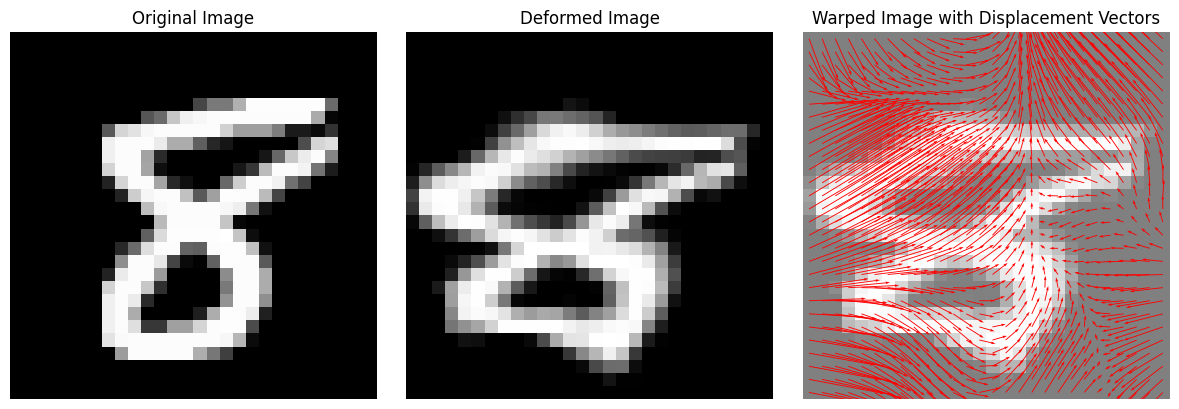

In [39]:
# Visualize elastic deformation on a random image
random_index = np.random.randint(0, len(x_train))
original_image = x_train[random_index, :, :, 0]  # Remove channel dimension for processing

# Apply deformation
deformed_image, dx, dy = elastic_deformation(original_image, alpha, sigma)

# Warp original image using displacement fields
x, y = np.meshgrid(np.arange(original_image.shape[1]), np.arange(original_image.shape[0]))
warped_x = x + dx
warped_y = y + dy

# Plot original, deformed, displacement fields, and warped image
plt.figure(figsize=(16, 4))


# Original image
plt.subplot(1, 4, 1)
plt.imshow(original_image, cmap='gray')
plt.title('Original Image')
plt.axis('off')

# Deformed image
plt.subplot(1, 4, 2)
plt.imshow(deformed_image, cmap='gray')
plt.title('Deformed Image')
plt.axis('off')

# Original displacement fields
#plt.subplot(1, 4, 3)
#magnitude_original = np.sqrt((dx * 0)**2 + (dy * 0)**2)  # Zero displacement fields for original image
#plt.imshow(magnitude_original, cmap='viridis')
#plt.title('Original Displacement')
#plt.colorbar(label='Displacement')
#plt.axis('off')

# Displacement fields
#plt.subplot(1, 4, 4)
#magnitude = np.sqrt(dx**2 + dy**2)
#plt.imshow(magnitude, cmap='viridis')
#plt.title('Deformed Displacement Magnitude')
#plt.colorbar(label='Displacement')
#plt.axis('off')


# Warped image
plt.subplot(1, 4, 3)
plt.imshow(deformed_image, cmap='gray', alpha=0.5)
plt.quiver(x, y, dx, dy, color='red', angles='xy', scale_units='xy', scale=1)
plt.title('Warped Image with Displacement Vectors')
plt.axis('off')

plt.tight_layout()
plt.show()

In [24]:
random.seed(2424)
# Augment 1% subset
x_aug_1, y_aug_1 = augment_subset_with_deformations(x_subset_percent1, y_subset_percent1, alpha, sigma)
x_subset_percent1_combined = np.concatenate([x_subset_percent1, x_aug_1])
y_subset_percent1_combined = np.concatenate([y_subset_percent1, y_aug_1])

# Augment 5% subset
x_aug_5, y_aug_5 = augment_subset_with_deformations(x_subset, y_subset, alpha, sigma)
x_subset_percent5_combined = np.concatenate([x_subset, x_aug_5])
y_subset_percent5_combined = np.concatenate([y_subset, y_aug_5])

In [25]:
random.seed(2424)
# Augment 1% subset 2ed
x_aug_1_2, y_aug_1_2 = augment_subset_with_deformations(x_subset_percent1, y_subset_percent1, alpha2, sigma2)
x_subset_percent1_combined_2 = np.concatenate([x_subset_percent1_combined, x_aug_1_2])
y_subset_percent1_combined_2 = np.concatenate([y_subset_percent1_combined, y_aug_1_2])

# Augment 5% subset 2ed
x_aug_5_2, y_aug_5_2 = augment_subset_with_deformations(x_subset, y_subset,  alpha2, sigma2)
x_subset_percent5_combined_2 = np.concatenate([x_subset_percent5_combined, x_aug_5_2])
y_subset_percent5_combined_2 = np.concatenate([y_subset_percent5_combined, y_aug_5_2])

In [47]:
random.seed(2424)
# Augment 1% subset 3ed
x_aug_1_3, y_aug_1_3 = augment_subset_with_deformations(x_subset_percent1, y_subset_percent1, alpha3, sigma3)
x_subset_percent1_combined_3 = np.concatenate([x_subset_percent1_combined_2, x_aug_1_3])
y_subset_percent1_combined_3 = np.concatenate([y_subset_percent1_combined_2, y_aug_1_3])

# Augment 5% subset 3ed
x_aug_5_3, y_aug_5_3 = augment_subset_with_deformations(x_subset, y_subset,  alpha3, sigma3)
x_subset_percent5_combined_3 = np.concatenate([x_subset_percent5_combined_2, x_aug_5_3])
y_subset_percent5_combined_3 = np.concatenate([y_subset_percent5_combined_2, y_aug_5_3])

In [33]:
print(f"Augmented subset size (including original, from -45 to 45 degrees): {x_subset_percent1_combined_3.shape[0]}")
print(f"Augmented subset size (including original, from -90 to 90 degrees): {y_subset_percent5_combined_3.shape[0]}")

Augmented subset size (including original, from -45 to 45 degrees): 2400
Augmented subset size (including original, from -90 to 90 degrees): 12000


In [27]:
# Cross-validation on the augmented 5% subset (1 ed)
mean_acc_augmented5, std_acc_augmented5 = cross_validate_cnn(x_subset_percent5_combined, y_subset_percent5_combined)
print(f"5% augmented subset - Mean accuracy: {mean_acc_augmented5:.4f}, Std: {std_acc_augmented5:.4f}")

# Train and evaluate on the augmented 5% subset (1 ed)
model = cnn_model(input_shape=(28, 28, 1))
model.fit(x_subset_percent5_combined, y_subset_percent5_combined, epochs=5, batch_size=64, verbose=1)
test_loss_augmented5, test_acc_augmented5 = model.evaluate(x_test, y_test, verbose=0)
print(f"Test accuracy on augmented 5% subset: {test_acc_augmented5:.4f}")

/home/bowmanm/anaconda3/envs/py310/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1734121708.756684     483 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 4057 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2060, pci bus id: 0000:2b:00.0, compute capability: 7.5
I0000 00:00:1734121710.694128     553 service.cc:148] XLA service 0x7fba0000aa30 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1734121710.694671     553 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 2060, Compute Capability 7.5
2024-12-13 15:28:30.749663: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] d

5% augmented subset - Mean accuracy: 0.9812, Std: 0.0046
Epoch 1/5
81/94 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5606 - loss: 1.3664

2024-12-13 15:28:50.080698: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=0} for conv (f32[48,32,26,26]{3,2,1,0}, u8[0]{0}) custom-call(f32[48,1,28,28]{3,2,1,0}, f32[32,1,3,3]{3,2,1,0}, f32[32]{0}), window={size=3x3}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]}
2024-12-13 15:28:50.145781: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=0} for conv (f32[48,64,11,11]{3,2,1,0}, u8[0]{0}) custom-call(f32[48,32,13,13]{3,2,1,0}, f32[64,32,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config=

94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.5916 - loss: 1.2742
Epoch 2/5
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9422 - loss: 0.1863
Epoch 3/5
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9735 - loss: 0.0969
Epoch 4/5
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9860 - loss: 0.0537
Epoch 5/5
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9937 - loss: 0.0308
Test accuracy on augmented 5% subset: 0.9674


In [28]:
# Cross-validation on the augmented 5% subset (2 ed)
mean_acc_augmented5, std_acc_augmented5 = cross_validate_cnn(x_subset_percent5_combined_2, y_subset_percent5_combined_2)
print(f"5% augmented subset - Mean accuracy: {mean_acc_augmented5:.4f}, Std: {std_acc_augmented5:.4f}")

# Train and evaluate on the augmented 5% subset (2 ed)
model = cnn_model(input_shape=(28, 28, 1))
model.fit(x_subset_percent5_combined_2, y_subset_percent5_combined_2, epochs=5, batch_size=64, verbose=1)
test_loss_augmented5, test_acc_augmented5 = model.evaluate(x_test, y_test, verbose=0)
print(f"Test accuracy on augmented 5% subset: {test_acc_augmented5:.4f}")

2024-12-13 15:29:00.672319: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=0} for conv (f32[32,32,26,26]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,1,28,28]{3,2,1,0}, f32[32,1,3,3]{3,2,1,0}, f32[32]{0}), window={size=3x3}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]}
2024-12-13 15:29:00.715977: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=0} for conv (f32[32,64,11,11]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,32,13,13]{3,2,1,0}, f32[64,32,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config=

5% augmented subset - Mean accuracy: 0.9934, Std: 0.0047
Epoch 1/5
139/141 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6973 - loss: 1.0598

2024-12-13 15:29:23.411938: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=0} for conv (f32[40,32,26,26]{3,2,1,0}, u8[0]{0}) custom-call(f32[40,1,28,28]{3,2,1,0}, f32[32,1,3,3]{3,2,1,0}, f32[32]{0}), window={size=3x3}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]}
2024-12-13 15:29:23.477909: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=0} for conv (f32[40,64,11,11]{3,2,1,0}, u8[0]{0}) custom-call(f32[40,32,13,13]{3,2,1,0}, f32[64,32,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config=

141/141 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.7004 - loss: 1.0489
Epoch 2/5
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9603 - loss: 0.1242
Epoch 3/5
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9850 - loss: 0.0546
Epoch 4/5
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9925 - loss: 0.0266
Epoch 5/5
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9978 - loss: 0.0137
Test accuracy on augmented 5% subset: 0.9752


In [48]:
# Cross-validation on the augmented 5% subset (3 ed)
mean_acc_augmented5, std_acc_augmented5 = cross_validate_cnn(x_subset_percent5_combined_3, y_subset_percent5_combined_3)
print(f"5% augmented subset - Mean accuracy: {mean_acc_augmented5:.4f}, Std: {std_acc_augmented5:.4f}")

# Train and evaluate on the augmented 5% subset (3 ed)
model = cnn_model(input_shape=(28, 28, 1))
model.fit(x_subset_percent5_combined_3, y_subset_percent5_combined_3, epochs=5, batch_size=64, verbose=1)
test_loss_augmented5, test_acc_augmented5 = model.evaluate(x_test, y_test, verbose=0)
print(f"Test accuracy on augmented 5% subset: {test_acc_augmented5:.4f}")

5% augmented subset - Mean accuracy: 0.9990, Std: 0.0009
Epoch 1/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.7262 - loss: 0.9146
Epoch 2/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9769 - loss: 0.0852
Epoch 3/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9907 - loss: 0.0307
Epoch 4/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9993 - loss: 0.0082
Epoch 5/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9997 - loss: 0.0031
Test accuracy on augmented 5% subset: 0.9752


In [29]:
# Cross-validation on the augmented 1% subset (1 ed)
mean_acc_augmented1, std_acc_augmented1 = cross_validate_cnn(x_subset_percent1_combined, y_subset_percent1_combined)
print(f"1% augmented subset - Mean accuracy: {mean_acc_augmented1:.4f}, Std: {std_acc_augmented1:.4f}")

# Train and evaluate on the augmented 1% subset (1 ed)
model = cnn_model(input_shape=(28, 28, 1))
model.fit(x_subset_percent1_combined, y_subset_percent1_combined, epochs=5, batch_size=64, verbose=1)
test_loss_augmented1, test_acc_augmented1 = model.evaluate(x_test, y_test, verbose=0)
print(f"Test accuracy on augmented 1% subset: {test_acc_augmented1:.4f}")

1% augmented subset - Mean accuracy: 0.9417, Std: 0.0087
Epoch 1/5
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - accuracy: 0.3170 - loss: 2.0962
Epoch 2/5
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7667 - loss: 0.7971
Epoch 3/5
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9023 - loss: 0.3152
Epoch 4/5
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9419 - loss: 0.2191
Epoch 5/5
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9756 - loss: 0.1166
Test accuracy on augmented 1% subset: 0.9272


In [30]:
# Cross-validation on the augmented 1% subset (2 ed)
mean_acc_augmented1, std_acc_augmented1 = cross_validate_cnn(x_subset_percent1_combined_2, y_subset_percent1_combined_2)
print(f"1% augmented subset - Mean accuracy: {mean_acc_augmented1:.4f}, Std: {std_acc_augmented1:.4f}")

# Train and evaluate on the augmented 1% subset (2 ed)
model = cnn_model(input_shape=(28, 28, 1))
model.fit(x_subset_percent1_combined_2, y_subset_percent1_combined_2, epochs=5, batch_size=64, verbose=1)
test_loss_augmented1, test_acc_augmented1 = model.evaluate(x_test, y_test, verbose=0)
print(f"Test accuracy on augmented 1% subset: {test_acc_augmented1:.4f}")

1% augmented subset - Mean accuracy: 0.9783, Std: 0.0089
Epoch 1/5
24/29 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.3721 - loss: 1.9916

2024-12-13 15:30:41.166460: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=0} for conv (f32[8,64,11,11]{3,2,1,0}, u8[0]{0}) custom-call(f32[8,32,13,13]{3,2,1,0}, f32[64,32,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]}


29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - accuracy: 0.4186 - loss: 1.8843
Epoch 2/5
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8738 - loss: 0.4040
Epoch 3/5
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9505 - loss: 0.1675
Epoch 4/5
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9777 - loss: 0.0933
Epoch 5/5
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9935 - loss: 0.0416
Test accuracy on augmented 1% subset: 0.9358


In [53]:
print(f"Augmented subset size (including original, from -45 to 45 degrees): {x_subset_percent5_combined.shape[0]}")
print(f"Augmented subset size (including original, from -90 to 90 degrees): {x_subset_percent1_combined.shape[0]}")

Augmented subset size (including original, from -45 to 45 degrees): 6000
Augmented subset size (including original, from -90 to 90 degrees): 1200


In [ ]:
# Train models and collect accuracy per epoch (This Function was taken out of the Paper)
datasets = [
    ("Full MNIST", x_train, y_train),
    ("5% MNIST", x_subset, y_subset),
    ("Rotation 45 Degree Range", x_combined_list1, y_combined_list1),
    ("Rotation 90 Degree Range", x_combined_list2, y_combined_list2),
    ("Rotation 180 Degree Range", x_combined_list3, y_combined_list3)
]

accuracy_per_epoch = {}
epochs = 10

for name, x_data, y_data in datasets:
    model = cnn_model(input_shape=(28, 28, 1))
    history = model.fit(x_data, y_data, validation_data=(x_test, y_test), epochs=epochs, batch_size=64, verbose=0)
    accuracy_per_epoch[name] = history.history['val_accuracy']

# Plot accuracy vs. epochs
plt.figure(figsize=(12, 8))
for name, accuracies in accuracy_per_epoch.items():
    plt.plot(range(1, epochs + 1), accuracies, marker='o', label=name)

plt.xlabel("Epochs")
plt.ylabel("Validation Accuracy")
plt.title("Validation Accuracy vs. Epochs for Different Datasets")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

In [ ]:
# Train models and collect accuracy per epoch (This Function was taken out of the Paper)
datasets = [
    ("Full MNIST", x_train, y_train),
    ("1% MNIST", x_subset_percent1, y_subset_percent1),
    ("Rotation 45 Degree Range", x_combined_list1_1, y_combined_list1_1),
    ("Rotation 90 Degree Range", x_combined_list2_1, y_combined_list2_1),
    ("Rotation 180 Degree Range", x_combined_list3_1, y_combined_list3_1)
]

accuracy_per_epoch = {}
epochs = 10

for name, x_data, y_data in datasets:
    model = cnn_model(input_shape=(28, 28, 1))
    history = model.fit(x_data, y_data, validation_data=(x_test, y_test), epochs=epochs, batch_size=64, verbose=0)
    accuracy_per_epoch[name] = history.history['val_accuracy']

# Plot accuracy vs. epochs
plt.figure(figsize=(12, 8))
for name, accuracies in accuracy_per_epoch.items():
    plt.plot(range(1, epochs + 1), accuracies, marker='o', label=name)

plt.xlabel("Epochs")
plt.ylabel("Validation Accuracy")
plt.title("Validation Accuracy vs. Epochs for Different Datasets")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

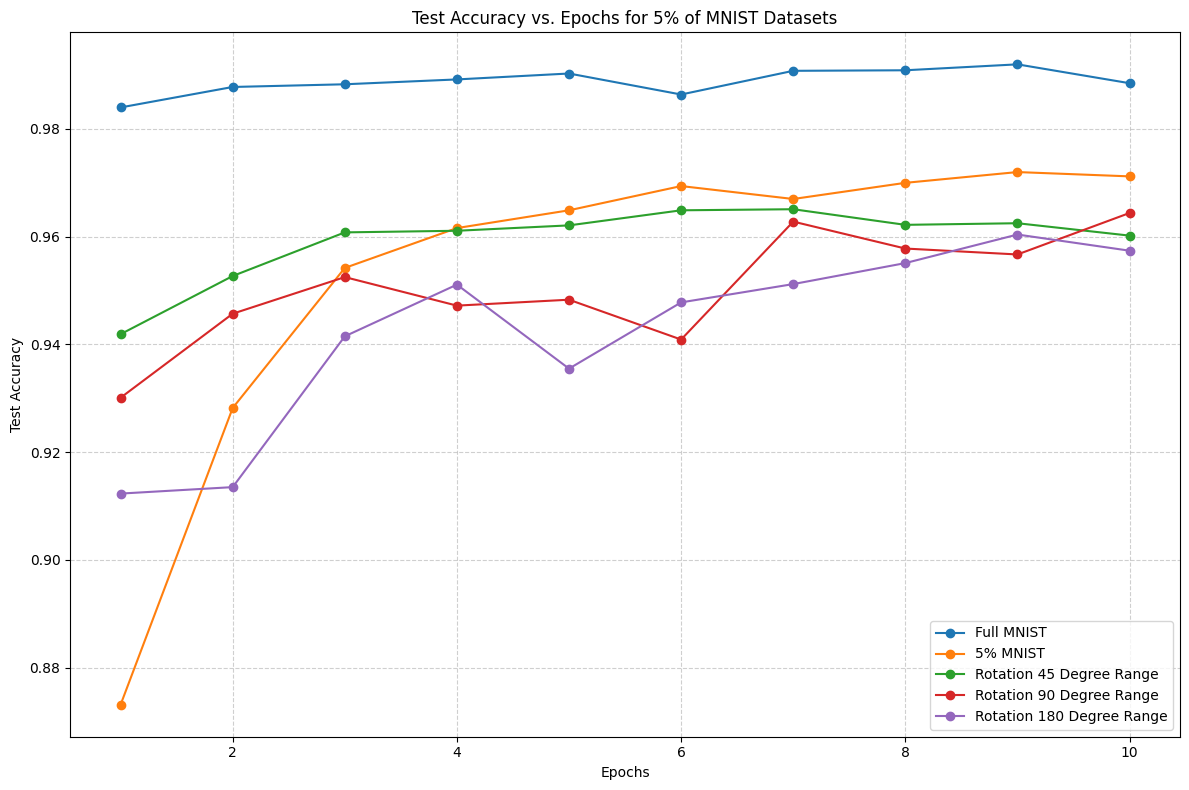

In [15]:
# Define a custom callback to record test accuracy (This Function was taken out of the Paper)
class TestAccuracyCallback(Callback):
    def __init__(self, x_test, y_test):
        self.x_test = x_test
        self.y_test = y_test
        self.test_accuracies = []

    def on_epoch_end(self, epoch, logs=None):
        test_loss, test_accuracy = self.model.evaluate(self.x_test, self.y_test, verbose=0)
        self.test_accuracies.append(test_accuracy)


# Train models and collect test accuracy per epoch
datasets = [
    ("Full MNIST", x_train, y_train),
    ("5% MNIST", x_subset, y_subset),
    ("Rotation 45 Degree Range", x_combined_list1, y_combined_list1),
    ("Rotation 90 Degree Range", x_combined_list2, y_combined_list2),
    ("Rotation 180 Degree Range", x_combined_list3, y_combined_list3)
]

test_accuracy_per_epoch = {}
epochs = 10

for name, x_data, y_data in datasets:
    model = cnn_model(input_shape=(28, 28, 1))
    test_accuracy_callback = TestAccuracyCallback(x_test, y_test)
    model.fit(
        x_data, y_data, 
        epochs=epochs, 
        batch_size=64, 
        verbose=0, 
        callbacks=[test_accuracy_callback]
    )
    test_accuracy_per_epoch[name] = test_accuracy_callback.test_accuracies

# Plot test accuracy vs. epochs
plt.figure(figsize=(12, 8))
for name, accuracies in test_accuracy_per_epoch.items():
    plt.plot(range(1, epochs + 1), accuracies, marker='o', label=name)

plt.xlabel("Epochs")
plt.ylabel("Test Accuracy")
plt.title("Test Accuracy vs. Epochs for 5% of MNIST Datasets")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

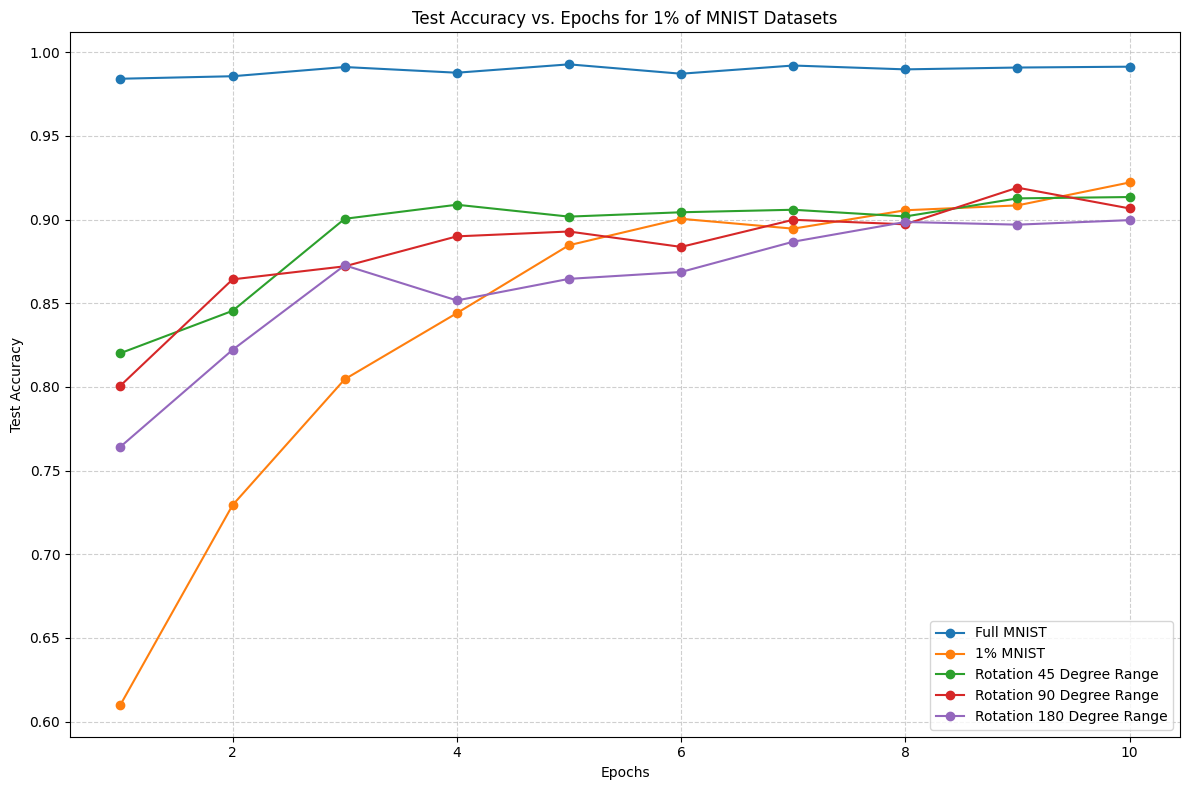

In [16]:
# Define a custom callback to record test accuracy (This Function was taken out of the Paper)
class TestAccuracyCallback(Callback):
    def __init__(self, x_test, y_test):
        self.x_test = x_test
        self.y_test = y_test
        self.test_accuracies = []

    def on_epoch_end(self, epoch, logs=None):
        test_loss, test_accuracy = self.model.evaluate(self.x_test, self.y_test, verbose=0)
        self.test_accuracies.append(test_accuracy)

# Train models and collect test accuracy per epoch
datasets = [
    ("Full MNIST", x_train, y_train),
    ("1% MNIST",x_subset_percent1, y_subset_percent1),
    ("Rotation 45 Degree Range", x_combined_list1_1, y_combined_list1_1),
    ("Rotation 90 Degree Range", x_combined_list2_1, y_combined_list2_1),
    ("Rotation 180 Degree Range", x_combined_list3_1, y_combined_list3_1)
]

test_accuracy_per_epoch = {}
epochs = 10

for name, x_data, y_data in datasets:
    model = cnn_model(input_shape=(28, 28, 1))
    test_accuracy_callback = TestAccuracyCallback(x_test, y_test)
    model.fit(
        x_data, y_data, 
        epochs=epochs, 
        batch_size=64, 
        verbose=0, 
        callbacks=[test_accuracy_callback]
    )
    test_accuracy_per_epoch[name] = test_accuracy_callback.test_accuracies

# Plot test accuracy vs. epochs
plt.figure(figsize=(12, 8))
for name, accuracies in test_accuracy_per_epoch.items():
    plt.plot(range(1, epochs + 1), accuracies, marker='o', label=name)

plt.xlabel("Epochs")
plt.ylabel("Test Accuracy")
plt.title("Test Accuracy vs. Epochs for 1% of MNIST Datasets")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

2024-12-04 16:31:31.348825: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=0} for conv (f32[64,32,26,26]{3,2,1,0}, u8[0]{0}) custom-call(f32[64,1,28,28]{3,2,1,0}, f32[32,1,3,3]{3,2,1,0}, f32[32]{0}), window={size=3x3}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kRelu","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]}
2024-12-04 16:31:31.420521: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=0} for conv (f32[64,64,11,11]{3,2,1,0}, u8[0]{0}) custom-call(f32[64,32,13,13]{3,2,1,0}, f32[64,32,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config=

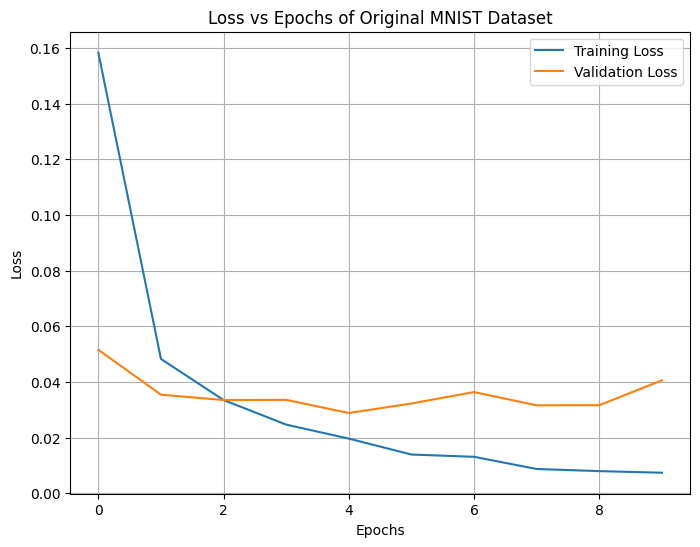

In [17]:
# Evaluate on the original model
model = cnn_model(input_shape=(28, 28, 1))
history = model.fit(x_train, y_train, epochs=10, batch_size=64, verbose=0, validation_data=(x_test, y_test))


# Plot the training and validation loss
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss vs Epochs of Original MNIST Dataset')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Split data for training and validation
#x_subset, x_val, y_subset, y_val = split_data(x_subset, y_subset)

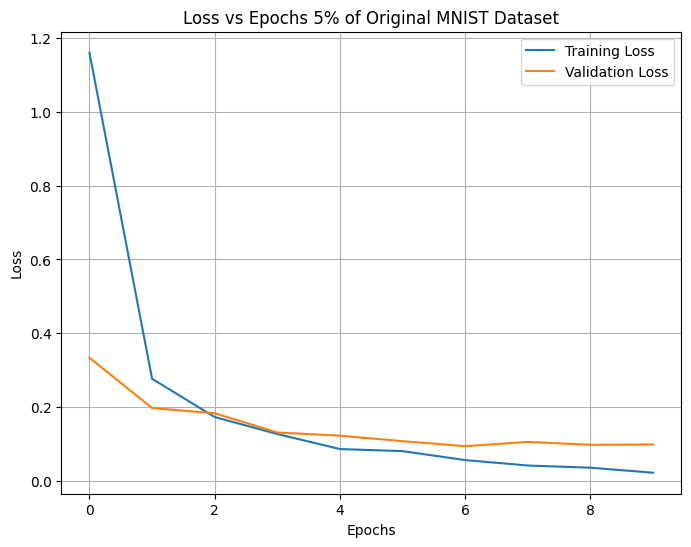

In [18]:
# Evaluate on the original 5% subset
model = cnn_model(input_shape=(28, 28, 1))
history = model.fit(x_subset, y_subset, epochs=10, batch_size=64, verbose=0, validation_data=(x_test, y_test))


# Plot the training and validation loss
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss vs Epochs 5% of Original MNIST Dataset')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

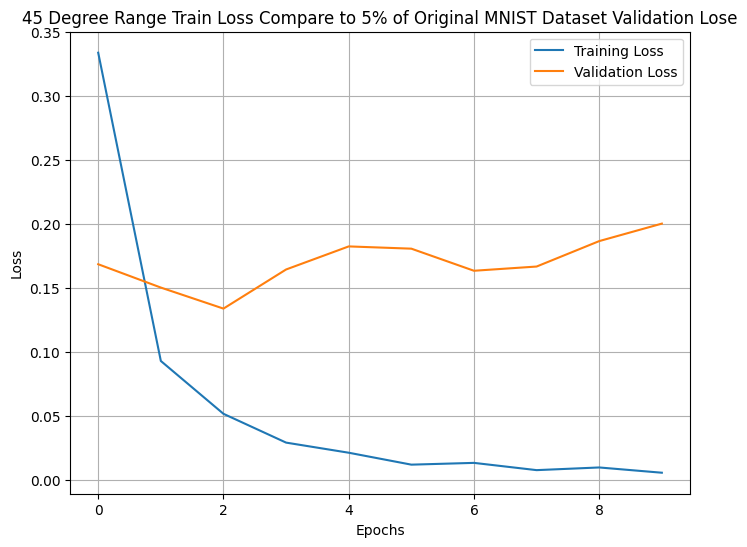

In [28]:
# Evaluate on the original 5% subset with 45 range
model = cnn_model(input_shape=(28, 28, 1))
history = model.fit(x_combined_list1, y_combined_list1, epochs=10, batch_size=64, verbose=0, validation_data=(x_test, y_test))


# Plot the training and validation loss
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('45 Degree Range Train Loss Compare to 5% of Original MNIST Dataset Validation Lose')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

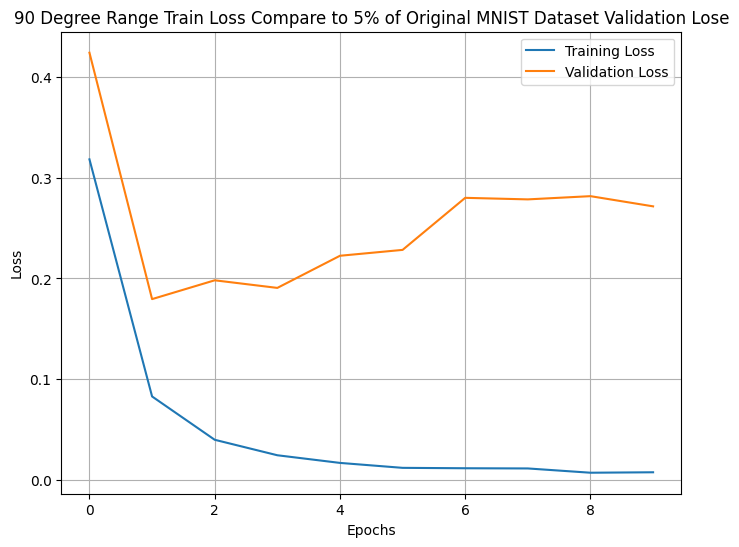

In [29]:
# Evaluate on the original 5% subset with 90 range
model = cnn_model(input_shape=(28, 28, 1))
history = model.fit(x_combined_list2, y_combined_list2, epochs=10, batch_size=64, verbose=0, validation_data=(x_test, y_test))


# Plot the training and validation loss
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('90 Degree Range Train Loss Compare to 5% of Original MNIST Dataset Validation Lose')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

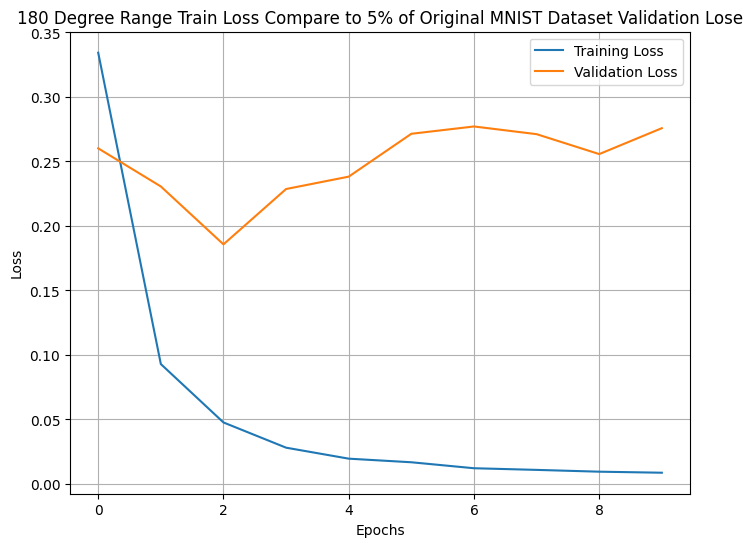

In [30]:
# Evaluate on the original 5% subset with 180 range
model = cnn_model(input_shape=(28, 28, 1))
history = model.fit(x_combined_list2, y_combined_list2, epochs=10, batch_size=64, verbose=0, validation_data=(x_test, y_test))


# Plot the training and validation loss
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('180 Degree Range Train Loss Compare to 5% of Original MNIST Dataset Validation Lose')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

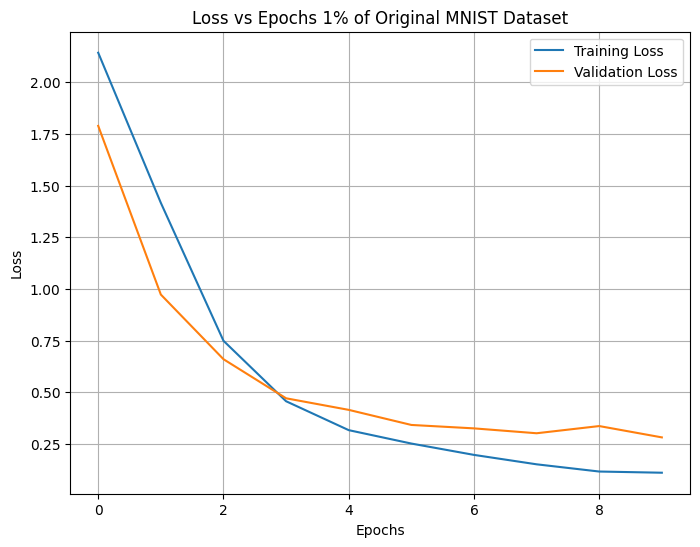

In [22]:
# Evaluate on the original 1% subset
model = cnn_model(input_shape=(28, 28, 1))
history = model.fit(x_subset_percent1, y_subset_percent1, epochs=10, batch_size=64, verbose=0, validation_data=(x_test, y_test))


# Plot the training and validation loss
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss vs Epochs 1% of Original MNIST Dataset')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

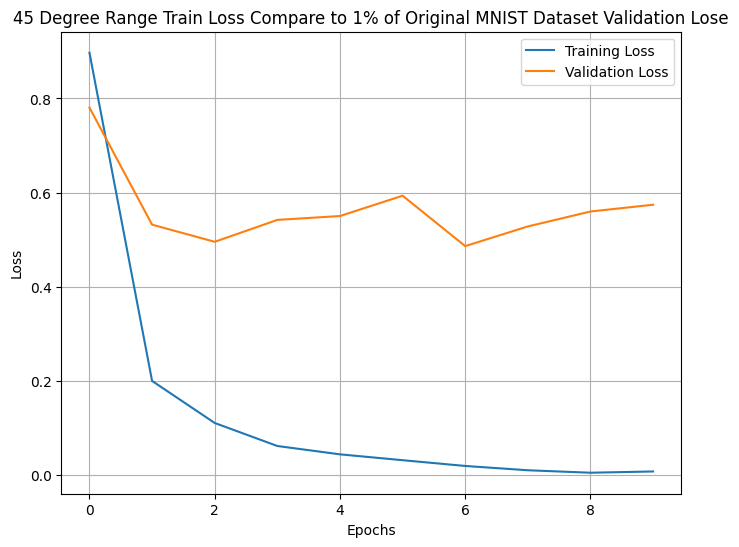

In [31]:
# Evaluate on the original 1% subset
model = cnn_model(input_shape=(28, 28, 1))
history = model.fit(x_combined_list1_1, y_combined_list1_1, epochs=10, batch_size=64, verbose=0, validation_data=(x_test, y_test))


# Plot the training and validation loss
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('45 Degree Range Train Loss Compare to 1% of Original MNIST Dataset Validation Lose')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

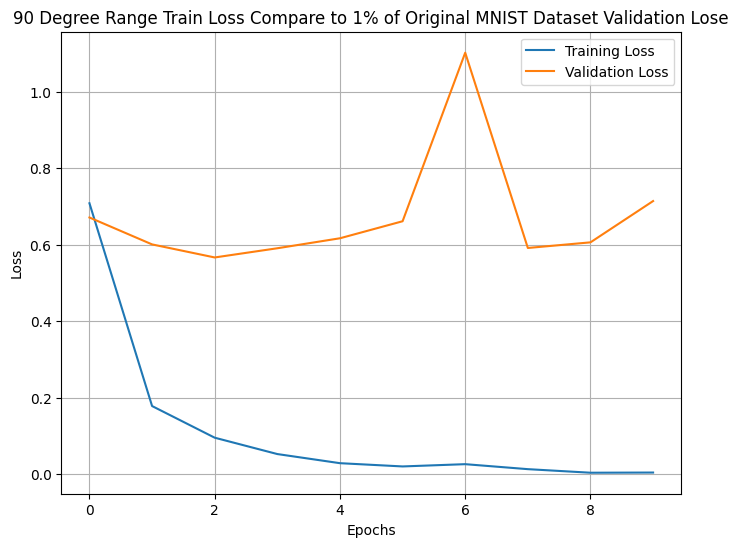

In [32]:
# Evaluate on the original 1% subset
model = cnn_model(input_shape=(28, 28, 1))
history = model.fit(x_combined_list2_1, y_combined_list2_1, epochs=10, batch_size=64, verbose=0, validation_data=(x_test, y_test))


# Plot the training and validation loss
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('90 Degree Range Train Loss Compare to 1% of Original MNIST Dataset Validation Lose')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

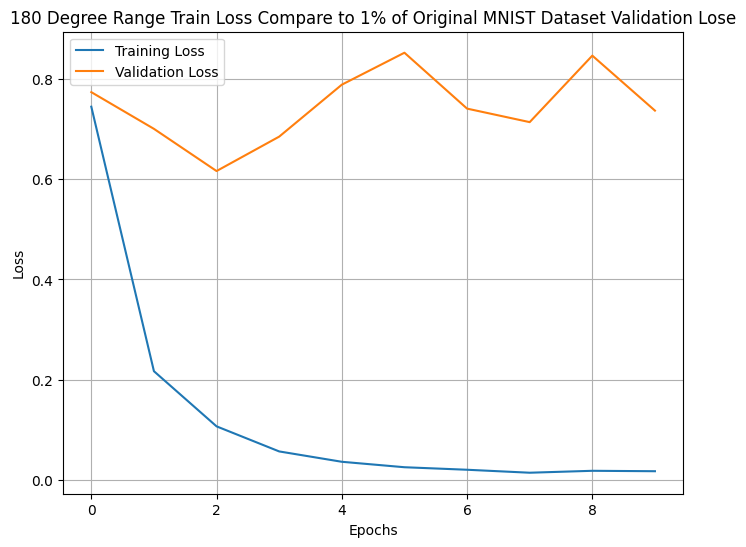

In [33]:
# Evaluate on the original 1% subset
model = cnn_model(input_shape=(28, 28, 1))
history = model.fit(x_combined_list3_1, y_combined_list3_1, epochs=10, batch_size=64, verbose=0, validation_data=(x_test, y_test))


# Plot the training and validation loss
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('180 Degree Range Train Loss Compare to 1% of Original MNIST Dataset Validation Lose')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

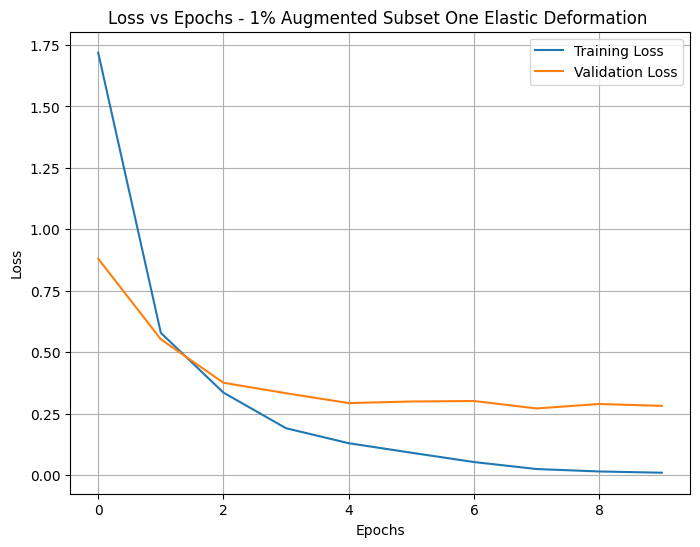

In [53]:
# Train and evaluate on the augmented 1% subset
model = cnn_model(input_shape=(28, 28, 1))
history_augmented1 = model.fit(x_subset_percent1_combined, y_subset_percent1_combined, epochs=10, batch_size=64, verbose=0, validation_data=(x_test, y_test))

# Plot training and validation loss for 1% augmented subset
plt.figure(figsize=(8, 6))
plt.plot(history_augmented1.history['loss'], label='Training Loss')
plt.plot(history_augmented1.history['val_loss'], label='Validation Loss')
plt.title('Loss vs Epochs - 1% Augmented Subset One Elastic Deformation ')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

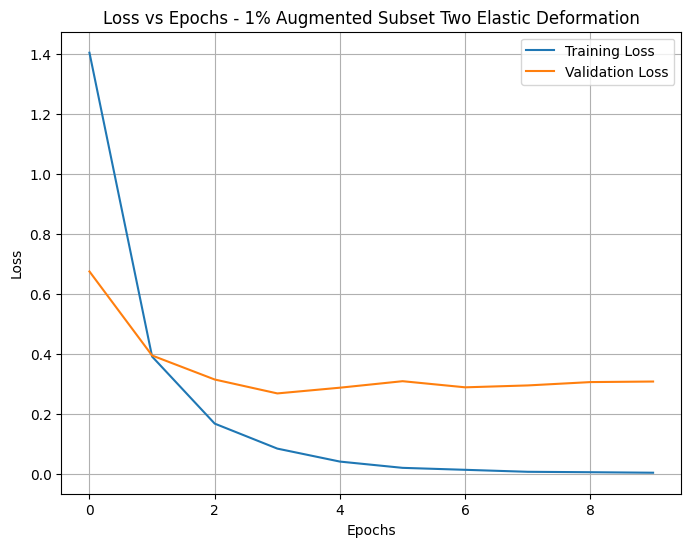

In [55]:
# Train and evaluate on the augmented 1% subset
model = cnn_model(input_shape=(28, 28, 1))
history_augmented1 = model.fit(x_subset_percent1_combined_2, y_subset_percent1_combined_2, epochs=10, batch_size=64, verbose=0, validation_data=(x_test, y_test))

# Plot training and validation loss for 1% augmented subset
plt.figure(figsize=(8, 6))
plt.plot(history_augmented1.history['loss'], label='Training Loss')
plt.plot(history_augmented1.history['val_loss'], label='Validation Loss')
plt.title('Loss vs Epochs - 1% Augmented Subset Two Elastic Deformation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

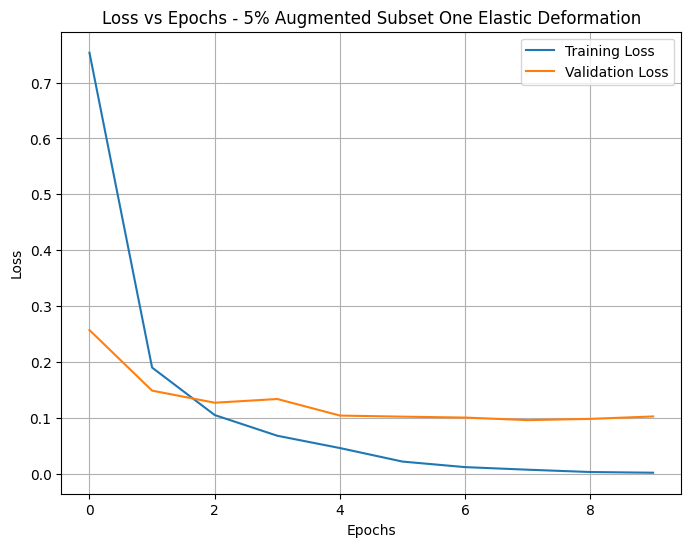

In [54]:
# Train and evaluate on the augmented 5% subset
model = cnn_model(input_shape=(28, 28, 1))
history_augmented5 = model.fit(x_subset_percent5_combined, y_subset_percent5_combined, epochs=10, batch_size=64, verbose=0, validation_data=(x_test, y_test))

# Plot training and validation loss for 5% augmented subset
plt.figure(figsize=(8, 6))
plt.plot(history_augmented5.history['loss'], label='Training Loss')
plt.plot(history_augmented5.history['val_loss'], label='Validation Loss')
plt.title('Loss vs Epochs - 5% Augmented Subset One Elastic Deformation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

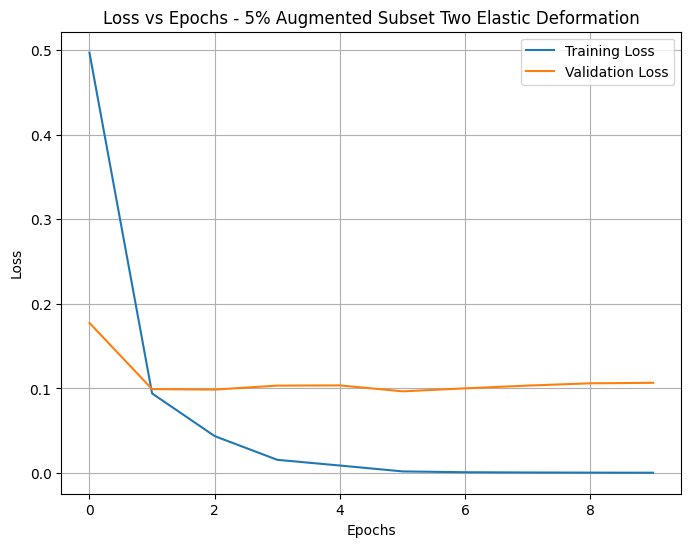

In [56]:
# Train and evaluate on the augmented 5% subset
model = cnn_model(input_shape=(28, 28, 1))
history_augmented5 = model.fit(x_subset_percent5_combined_2, y_subset_percent5_combined_2, epochs=10, batch_size=64, verbose=0, validation_data=(x_test, y_test))

# Plot training and validation loss for 5% augmented subset
plt.figure(figsize=(8, 6))
plt.plot(history_augmented5.history['loss'], label='Training Loss')
plt.plot(history_augmented5.history['val_loss'], label='Validation Loss')
plt.title('Loss vs Epochs - 5% Augmented Subset Two Elastic Deformation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()